# Model1 CNN+LSTM
version 0.1.b.2

## Implementation detals
- Input size: -1 x 2 x 90 x 100
- Output size: -1 x 1 / -1 x 3
<br></br>
- X: CSI (magnitude + phase)
- Y: side label
## Version Info
- Mapping from CSI to side labels (0, 1, 2)
- Only uses dynamic data

In [23]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
import TrainingPresets as TP

## Model

In [97]:
class MyEncodeCNN(nn.Module):
    def __init__(self):
        super(MyEncodeCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=(3, 1), padding=0),
            #nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 90 * 100 * 1
            # Out = 30 * 98 * 16
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=(1, 1), padding=0),
            #nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 30 * 98 * 16
            # Out = 26 * 94 * 32
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=(1, 1), padding=0),
            #nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 26 * 94 * 32
            # Out = 22 * 90 * 64
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=(1, 1), padding=0),
            #nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 22 * 90 * 64
            # Out = 18 * 86 * 128
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=(1, 1), padding=0),
            #nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 18 * 86 * 128
            # Out = 14 * 82 * 256
        )
        
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=(14, 82), stride=1, padding=0)
        )
        
        self.fclayers = nn.Sequential(
            nn.Linear(128, 4096),
            nn.ReLU(),
            nn.Linear(4096, 512),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.gap(x)

        # x = self.dropout(x)
        #x = self.fclayers(x)
        return x
        #return x.view(-1, 18 * 128, 86)


class MyEncodeLSTM(nn.Module):
    def __init__(self):
        super(MyEncodeLSTM, self).__init__()

        self.hidden_size = 128
        self.num_layers = 2

        self.layer = nn.LSTM(128 * 18 * 2, self.hidden_size, self.num_layers, batch_first=True, dropout=0.1)

    def forward(self, x):
        out, (final_hidden_state, final_cell_state)  = self.layer(x)
        return out

class MyEncodeFC(nn.Module):
    def __init__(self):
        super(MyEncodeFC, self).__init__()

        self.fclayers = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Linear(4096, 128),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.fclayers(x)
        return x

class MyEncoder(nn.Module):
    def __init__(self):
        super(MyEncoder, self).__init__()
        self.cnn1 = MyEncodeCNN()
        self.cnn2 = MyEncodeCNN()
        #self.lstm = MyEncodeLSTM()
        self.fc = MyEncodeFC()

    def forward(self, x):
        x = torch.chunk(x.view(-1, 2, 90, 100), 2, dim=1)
        x1 = self.cnn1.forward(x[0])
        x2 = self.cnn2.forward(x[1])

        # size_x = batch_size * 18 * 86

        out = torch.cat([x1, x2], dim=1)
        #size_out = batch_size * 128 * 86
        #out = self.lstm.forward(out.transpose(1, 2))
        out = self.fc(out)
        
        return out


class MyDecodeFC(nn.Module):
    def __init__(self):
        super(MyDecodeFC, self).__init__()

        self.fclayers = nn.Sequential(
            nn.Linear(128, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),)
        
        self.onehotout = nn.Sequential(
            nn.Linear(4096, 3),
         )
        
        self.singleout = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fclayers(x)
        x = self.onehotout(x)
        return x

    
class MyDecodeLSTM(nn.Module):
    def __init__(self):
        super(MyDecodeLSTM, self).__init__()

        self.hidden_size = 128
        self.num_layers = 2
        self.hidden = self.init_hidden()

        self.layer = nn.LSTM(128, self.hidden_size, self.num_layers, batch_first=True, dropout=0.1)

    def init_hidden(self):
        # Only for initialization
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

    def forward(self, x):
        out, (final_hidden_state, final_cell_state)  = self.layer(x)
        return out[:, -1, :]

    
class MyDecoder(nn.Module):
    def __init__(self):
        super(MyDecoder, self).__init__()

        #self.lstm = MyDecodeLSTM()
        self.fc = MyDecodeFC()

    def forward(self, x):
        #x = self.lstm.forward(x)
        x = self.fc.forward(x)
        return x
    
    
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.encoder = MyEncoder()
        self.decoder = MyDecoder()

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z) 
        return y

In [103]:
torch.cuda.get_device_name(0)
m1 = MyEncoder().to(torch.device("cuda:1"))
summary(m1, input_size=(2, 90, 100))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Sequential: 2, Conv2d: 3, LeakyReLU: 3, Sequential: 2, Conv2d: 3, LeakyReLU: 3, Sequential: 2, Conv2d: 3, LeakyReLU: 3, Sequential: 2, Conv2d: 3, LeakyReLU: 3, Sequential: 2, Conv2d: 3, LeakyReLU: 3, Sequential: 2, AvgPool2d: 3, Sequential: 2, Conv2d: 3, LeakyReLU: 3, Sequential: 2, Conv2d: 3, LeakyReLU: 3, Sequential: 2, Conv2d: 3, LeakyReLU: 3, Sequential: 2, Conv2d: 3, LeakyReLU: 3, Sequential: 2, Conv2d: 3, LeakyReLU: 3, Sequential: 2, AvgPool2d: 3]

## Dataset

In [69]:
datadir = '../Dataset/0302make00/'
print(os.listdir(datadir))

['sid.npy', 'csi.npy']


In [70]:
mydata = TP.MyDataset(datadir + 'csi.npy', datadir + 'sid.npy')
print(mydata.data['x'].shape, mydata.data['y'].shape)

train_size = int(len(mydata) * 0.7)
valid_size = int(len(mydata) * 0.2)
test_size = int(len(mydata)) - train_size - valid_size
print(train_size, valid_size, test_size)

train_loader, valid_loader, test_loader = TP.split_loader(mydata, train_size, valid_size, test_size, 8)

loaded
(3000, 2, 100, 90) (3000,)
2100 600 300
2100 600 300


## Running gears

In [10]:
# Hyperparameters
args = TP.MyArgs(cuda=1, epochs=100, learning_rate=0.001, criterion=nn.CrossEntropyLoss())

In [76]:
# Model and Loss

model = MyModel().to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

train_loss = []
valid_loss = []
train_epochs_loss = []
valid_epochs_loss = []

# early_stopping = EarlyStopping(patience=args.patience,verbose=True)

In [77]:
# Training and Saving
start = time.time()

for epoch in range(args.epochs):
    model.train()
    train_epoch_loss = []
    for idx,(data_x,data_y) in enumerate(train_loader,0):
        data_x = data_x.to(torch.float32).to(args.device)
        data_y = data_y.to(torch.long).to(args.device)
        optimizer.zero_grad()
        outputs = model(data_x)
        loss = criterion(outputs, data_y)
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
        train_loss.append(loss.item())
        if idx%(len(train_loader)//2)==0:
            print("\repoch={}/{},{}/{}of train, loss={}".format(
            epoch, args.epochs, idx, len(train_loader),loss.item()), end='')
    train_epochs_loss.append(np.average(train_epoch_loss))

end = time.time()
print("\nTotal training time:", end-start, "sec")
  
  #=====================valid============================
model.eval()
valid_epoch_loss = []
for idx,(data_x,data_y) in enumerate(valid_loader,0):
    data_x = data_x.to(torch.float32).to(args.device)
    data_y = data_y.to(torch.long).to(args.device)
    outputs = model(data_x)
    loss = criterion(outputs,data_y)
    valid_epoch_loss.append(loss.item())
    valid_loss.append(loss.item())
valid_epochs_loss.append(np.average(valid_epoch_loss))

  #==================early stopping======================
  # early_stopping(valid_epochs_loss[-1],model=MyModel,path=r'')
  # if early_stopping.early_stop:
  #    print("Early stopping")
  #    break
  #====================adjust lr========================
lr_adjust = {
    2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
    10: 5e-7, 15: 1e-7, 20: 5e-8
}
  #if epoch in lr_adjust.keys():
  #    lr = lr_adjust[epoch]
  #    for param_group in optimizer.param_groups:
  #        param_group['lr'] = lr
  #    print('Updating learning rate to {}'.format(lr))

#torch.save(model.state_dict(), '../Models/v01b2_ep300.pth')


epoch=99/100,131/262of train, loss=0.065668559074402
Total training time: 1280.6852865219116 sec


## Visualization of Training Process

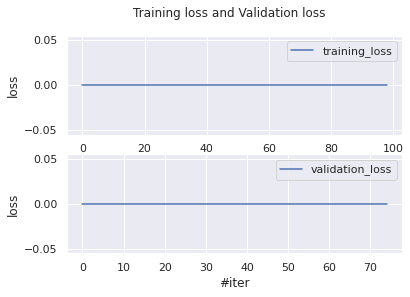

In [78]:
# Plot loss curves

%matplotlib inline
plt.figure()
plt.clf()
plt.suptitle("Training loss and Validation loss")
plt.subplot(2, 1, 1)
plt.plot(train_epochs_loss[1:], 'b', label = 'training_loss')
plt.ylabel('loss')
plt.xlabel('#epoch')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(valid_loss, 'b', label = 'validation_loss')
plt.ylabel('loss')
plt.xlabel('#iter')
plt.legend()
#plt.savefig("loss_900epoch_down.jpg")

In [64]:
print(np.array(train_epochs_loss).shape, np.array(valid_epochs_loss).shape)
print(np.array(train_loss).shape, np.array(valid_loss).shape)

(200,) (2,)
(52400,) (150,)


## Load from checkpoint

In [79]:
# If you want to train from a certain checkpoint

#model = torch.load('../Models/v0_ep500_lr001.pth')
model.load_state_dict(torch.load('../Models/v0_ep500_lr001.pth'))
model.cuda()

# Reload the loss curve
preserve = 500
# 3 iter per epoch
train_loss = train_loss[:preserve * 3]
# discard following epoch values
train_epochs_loss = train_epochs_loss[:preserve]

# re-validate
valid_loss = []
valid_epochs_loss = []

args = MyArgs(epochs=200, learning_rate=0.0001)

AttributeError: Can't get attribute 'MyDecodeCNN' on <module '__main__'>

## Estimation
Test performance

In [80]:
  #=====================test============================
estimate = []
test_loss = []
ground_truth = []
model.eval()
for idx,(data_x,data_y) in enumerate(test_loader,0):
    data_x = data_x.to(torch.float32).to(args.device)
    data_y = data_y.to(torch.long).to(args.device)
    outputs = model(data_x)
    loss = criterion(outputs,data_y)
    estimate.append(outputs.cpu().detach().numpy().squeeze().tolist())
    ground_truth.append(data_y.cpu().detach().numpy().squeeze().tolist())
    test_loss.append(loss.item())
    if idx%(len(test_loader)//5)==0:
        print("\r{}/{}of test, loss={}".format(
        idx, len(test_loader),loss.item()), end='')

240/300of test, loss=0.0

Confusion matrix

Text(30.5, 0.5, 'true')

<Figure size 432x288 with 0 Axes>

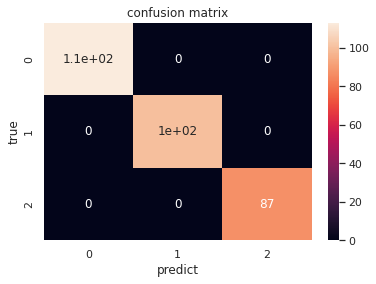

In [81]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline

def fromonehot(inlist):
    out = []
    for item in inlist:
        if np.argmax(item) == 0:
            out.append(0)
        elif np.argmax(item) == 1:
            out.append(1)
        elif np.argmax(item) == 2:
            out.append(2)
    return out

predicted = [np.argmax(row) for row in estimate]

plt.figure()
sns.set()
f,ax=plt.subplots()
cf = confusion_matrix(ground_truth, predicted)

sns.heatmap(cf,annot=True,ax=ax) 

ax.set_title('confusion matrix') 
ax.set_xlabel('predict') 
ax.set_ylabel('true')

In [ ]:
%matplotlib inline
data = torch.tensor(csis, dtype=torch.float32, device='cuda:1')
for i in range(len(data)):
    predictions = model(data[i])
    pred = predictions.cpu().detach().numpy()[0, 0]
    plt.figure()
    plt.imshow(pred)
    plt.show()